In [51]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt 
from numpy.linalg import eigvals

In [64]:
def first_eqs(t, m, s):
    s = float(s) # ensure python float for stability 
    
    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = 9 * s / (4 * t) 
    b = m / t 
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    exp1 = np.exp(a) 
    cosh = np.cosh(b) 

    denom =  2 + exp1 * cosh
    # avoid division by zero
    if denom == 0:
        return 1e6
    
    return -1 + s + 3 / denom

def second_eqs(t, m, s):
    s = float(s) # ensure python float for stability 

    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = 9 * s / (4 * t) 
    b = m / t
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    exp1 = np.exp(a) 
    cosh = np.cosh(b) 
    tanh = np.tanh(b)

    denom = 2 + exp1 * cosh
    # avoid division by zero
    if denom == 0:
        return 1e6
    return m + ( -1 + 2.0 / denom ) * tanh
 

def bound_equations(t, vars_): 
    s, m = vars_
    return [first_eqs(t, m, s), second_eqs(t, m, s)]   


def hessian(t, m, S): 

    safe_clip = 700.0
    a = (9/4) * S / t
    b = m / t
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    
    #precompute recurring terms with safe clip
    exp1 = np.exp(a)
    cosh = np.cosh(b) 
    sinh = np.sinh(b) 

    #common denominators
    denom1 = (2 + exp1*cosh)*(2 + exp1*cosh)
    denom2 = 8*t + 4*exp1*t*cosh 

    # guard denominators
    if not np.isfinite(denom1) or abs(denom1) < 1e-300:
        denom1 = np.sign(denom1) * 1e-300
    if not np.isfinite(denom2) or abs(denom2) < 1e-300:
        denom2 = np.sign(denom2) * 1e-300 

    #individual Hessian elements 
    H11 = 1 + 9/(4*t*denom1) - 9/denom2
    H12 = 9/(4*t*denom1) 
    H13 = (9*exp1*cosh)/(4*t*denom1) 
    H16 = (3*exp1*sinh)/(2*t*denom1) 
    H36 = -(3*exp1*sinh)/(t*denom1) 
    H44 = 1 - 1 / (2*t + exp1*t*cosh)
    H66 = 1 - (-4+ exp1)/(t*denom1) - 2/(2*t + exp1*t*cosh)
    # full Hessian matrix 
    hessian_matrix = np.array([
        [H11, H12, H13, 0.0, 0.0, H16],
        [H12, H11, H13, 0.0, 0.0, H16],
        [H13, H13, H11, 0.0, 0.0, H36],
        [0.0, 0.0, 0.0, H44, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, H44, 0.0],
        [H16, H16, H36, 0.0, 0.0, H11]
    ])

    # make symmetric
    hessian_matrix = 0.5 * (hessian_matrix + hessian_matrix.T)

    return hessian_matrix


def stability_check(t, m, S, tol=1e-9):
    #return False (unstable / not defined) if any input is NaN or not finite
    if not (np.isfinite(t) and np.isfinite(m) and np.isfinite(S)):
        return False
    
    H = hessian(t, m, S)

    # check the matrix itself
    if not np.all(np.isfinite(H)):
        return False
    
    e = np.real_if_close(eigvals(H))
    # require all eigenvalues strictly greater than tol
    return np.all(e > tol)


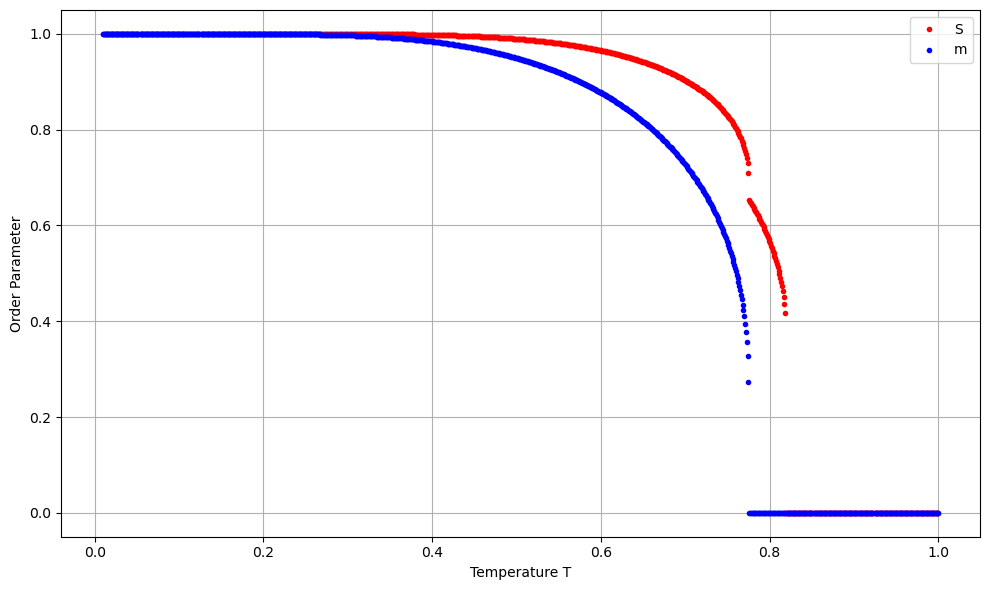

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------- Free energy function ----------
def free_energy(t, S, m):
    # 1/4 * ( 2 m^2 + 3 S^2 - 4 t * log( 2 e^{-3 S /(4 t)} ( 2 + e^{9 S /(4 t)} cosh(m/t) ) ) )
    return 0.25 * (
        2.0 * m**2
        + 3.0 * S**2
        - 4.0 * t
        * np.log(
            2.0 * np.exp(-3.0 * S / (4.0 * t))
            * (2.0 + np.exp(9.0 * S / (4.0 * t)) * np.cosh(m / t))
        )
    )

# ---------- Minimizer at a fixed temperature ----------
def minimize_free_energy(t, guess=(1.0, 1.0)):
    """
    Minimize F(t,S,m) for given t.
    Returns (S,m) or (np.nan, np.nan) if it fails.
    """
    def F(vars_):
        S, m = vars_
        return free_energy(t, S, m)

    # Bounds: adjust if S or m can be negative in your model
    bounds = [(0.0, 1.0), (0.0, 1.0)]
    res = minimize(F, guess, method="L-BFGS-B", bounds=bounds, tol=1e-10)

    if res.success:
        return res.x
    else:
        return (np.nan, np.nan)

# ---------- Sweep over temperatures ----------
T_vals = np.linspace(0.01, 1.0, 1000)  # avoid t=0 to prevent division by zero
S_vals, m_vals = [], []
guess = (1.0, 1.0)  # initial guess for (S,m)

for t in T_vals:
    S, m = minimize_free_energy(t, guess)
    S_vals.append(S)
    m_vals.append(m)
    # continuation: next guess starts near previous solution
    if np.isfinite(S) and np.isfinite(m):
        guess = (S, m)
    else:
        guess = (1.0, 1.0)  # fallback if minimization fails

# ---------- Plot ----------
plt.figure(figsize=(10, 6))
plt.plot(T_vals, S_vals, 'r.', label='S')
plt.plot(T_vals, m_vals, 'b.', label='m')
plt.xlabel("Temperature T")
plt.ylabel("Order Parameter")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

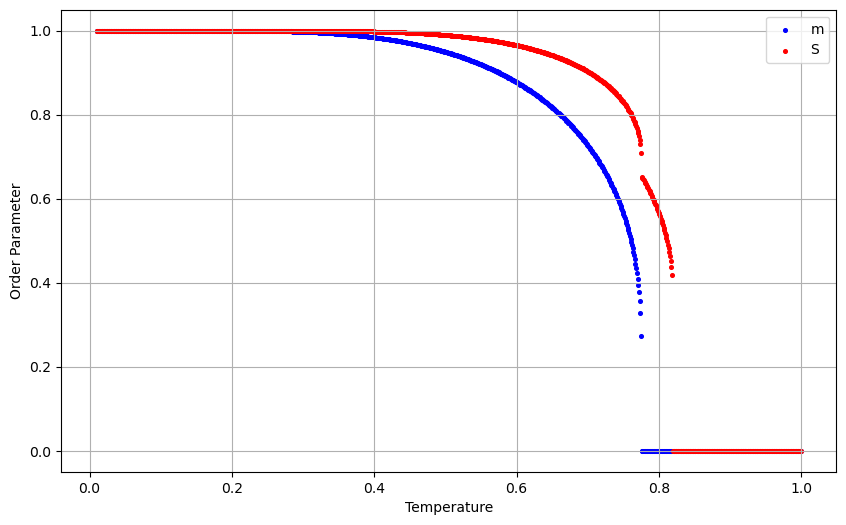

In [85]:
for t in T_vals: 
    #Solve for s and m 
    sol = root(lambda vars_: bound_equations(t, vars_), [S_vals[-1] if S_vals else 1.0, m_vals[-1] if m_vals else 1.0], method = 'hybr', tol=1e-14) 

    if sol.success: 
        S_vals.append(sol.x[0])
        m_vals.append(sol.x[1])
    else: 
        # Using a different method - 'lm' (Levenberg-Marquardt)
        sol = root(lambda vars_: bound_equations(t, vars_), [S_vals[-1] if S_vals else 1.0, m_vals[-1] if m_vals else 1.0], method = 'lm') 
        if sol.success: 
            S_vals.append(sol.x[0])
            m_vals.append(sol.x[1]) 
        else: 
            S_vals.append(np.nan)
            m_vals.append(np.nan) 
            # Mark failure 

s_stable=[]
m_stable = []
t_stable=[]

for i in range(len(T_vals)): 
    if stability_check(T_vals[i], m_vals[i] , S_vals[i]):
        s_stable.append(S_vals[i]) 
        t_stable.append(T_vals[i])  
        m_stable.append(m_vals[i])

# Plot
plt.figure(figsize=(10, 6))

plt.scatter(t_stable, m_stable, label=r'm', color='blue',s=7) 
plt.scatter(t_stable, s_stable, label=f'S', color='red',s=7)

plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.legend()
plt.grid(True) 
plt.show() 

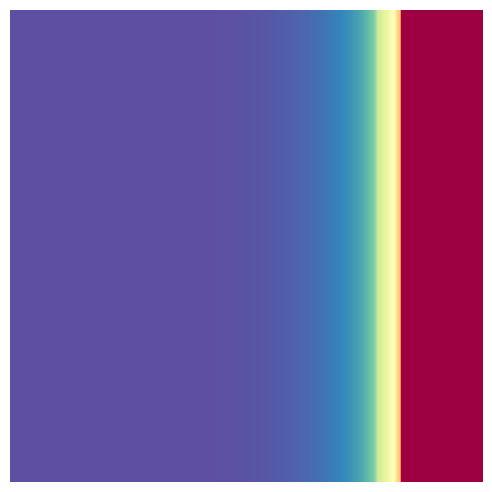

In [ ]:
n = len(m_vals) 
stability_map = np.full((n, n), 0, dtype=float)  

for line, m in enumerate(m_vals):
    for column, (t, S) in enumerate(zip(T_vals, S_vals)):
        stability_map[line, column] = S   

np.savetxt('Stability_map.txt', stability_map, delimiter=' ', fmt='%f') 

data = np.loadtxt("Stability_map.txt")
data = np.ma.masked_invalid(data) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off') 
plt.tight_layout(pad=0)
plt.savefig("heatmap.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)


In [33]:
def first_eqs(t, m, s):
    s = float(s) # ensure python float for stability 
    
    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = 9 * s / (4 * t) 
    b = m / t 
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    exp1 = np.exp(a) 
    cosh = np.cosh(b) 

    denom =  2 + exp1 * cosh
    # avoid division by zero
    if denom == 0:
        return 1e6
    
    return -1 + s + 3 / denom

def second_eqs(t, m, s):
    s = float(s) # ensure python float for stability 

    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = 9 * s / (4 * t) 
    b = m / t
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    exp1 = np.exp(a) 
    cosh = np.cosh(b) 
    tanh = np.tanh(b)

    denom = 2 + exp1 * cosh
    # avoid division by zero
    if denom == 0:
        return 1e6
    return m + ( -1 + 2.0 / denom ) * tanh
 

def bound_equation(t, m, s): 
    
    return [first_eqs(t, m, s), second_eqs(t, m, s)] 


m_sample = np.linspace(0.01, 1.0, 500)  
n = len(m_sample) 

stability_map = np.full((n, n), 0, dtype=float) 

for line, m in enumerate(m_sample):
    T_vals = np.linspace(0.01, 1.0, 500)
    S_vals = []

    for t in T_vals: 
        #Solve for s and m 
        sol = root(lambda s: bound_equation(t, m, s), [S_vals[-1] if S_vals else 1.0]) 

        if sol.success: 
            S_vals.append(sol.x[0])
        else: 
            # Using a different method - 'lm' (Levenberg-Marquardt)
            sol = root(lambda s: bound_equation(t, m, s), [S_vals[-1] if S_vals else 1.0], method = 'lm') 
            if sol.success: 
                S_vals.append(sol.x[0])
            else: 
                S_vals.append(np.nan) # Mark failure  


    for column, (t, S) in enumerate(zip(T_vals, S_vals)):
        stability_map[line, column] = S  

    # Saving stable points for each m
    stable_indices = np.where(~np.isnan(stability_map[line]))
    S_stable = stability_map[line][stable_indices]
    T_stable = T_vals[stable_indices]

    np.savetxt(f'Data/Uniaxial_{line+1}.csv', np.column_stack((S_stable, T_stable)), 
               delimiter=' ', fmt='%f', header=f'Constant m: {m}\nS_vals T_vals')

np.savetxt('Stability_map.txt', stability_map, delimiter=' ', fmt='%f')

/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_10532/3150373203.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = float(s) # ensure python float for stability
/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_10532/3150373203.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = float(s) # ensure python float for stability


ValueError: The array returned by a function changed size between calls